# Initial training on reduced sample of images
The network is initially trained using just the first 200 games, split into 80/20 ratio as train/validation sets.

## initial setup:

In [1]:
# auto reloading and inline display of matplotlib output:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# import fastai external dependencies
from fastai.imports import *

In [4]:
# import the various fastai functions (mainly wrappers around scikit-learn and pytorch functions)
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# check we're in right directory (should be /c/code/alexis)
!pwd

/c/code/alexis


In [5]:
# set root path for our training samples:
PATH = "data/subset/"

# size to scale images to:
sz=256

In [12]:
# check NVidia GPU is working (should return True):
torch.cuda.is_available()

True

In [13]:
# check CuDNN library is available:
torch.backends.cudnn.enabled

True

In [14]:
# check we have a 'train' and 'valid' directory
os.listdir(PATH)

['models', 'train', 'valid']

In [15]:
# each folder has subfolders for each category 
# (should be 'best' for 'best moves' generated by quackle 
# and 'not_best' for other moves generated by alexis:

os.listdir(f'{PATH}valid')

['best', 'not_best']

In [16]:
files = os.listdir(f'{PATH}valid/best')
files[:10] # just look at the first few

['q_g0001_move02_option2.png',
 'q_g0001_move07_option1.png',
 'q_g0001_move09_option1.png',
 'q_g0001_move10_option2.png',
 'q_g0001_move12_option2.png',
 'q_g0001_move16_option1.png',
 'q_g0001_move17_option2.png',
 'q_g0002_move03_option1.png',
 'q_g0002_move03_option2.png',
 'q_g0002_move04_option1.png']

In [17]:
len(files)

1803

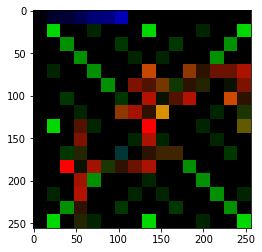

In [18]:
# here's a sample image

img = plt.imread(f'{PATH}valid/best/{files[100]}')
plt.imshow(img);

Here is how the shape of the raw data:

In [19]:
img.shape

(256, 256, 3)

In [20]:
#here's the raw data, triplets of [R, G, B] values (quite sparse - most squares don't have a multiplier, or a tile):
img

array([[[0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        ...,
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ]],

       [[0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        ...,
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ]],

       [[0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        [0.     , 0.     , 0.03529],
        ...,
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ]],

       ...,

       [[0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     ],
        ...,
        [0.     , 0.84706, 0.     ],
        [0.     , 0.84706, 0.     ],
        [0.     , 0.84706, 0.     ]],

       [[0.     , 0.     , 0.     ],
  

# Now train a neural network:

### download ResNet18 architecture:

In [21]:
# Uncomment to reset precomputed activations:
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [6]:
arch=resnet18
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

# learn is the main CNN object containing a description of the architecture and weights of each node
learn = ConvLearner.lsuv_learner(arch, data, precompute=False)

### calculate optimal learning rate:

the learning rate is an important hyperparamer. It controls how quickly we adjust the weights in the network when updating them - too small and we will crawl to a solution and potentially get stuck in local minima, too high and we will bounce around the multi-dimensional surface describing our function  without settling into a stable minimum point.

learn.lr_find() uses the technique from Smith (2015) to determine an optimal rate - we keep increasing the learning rate each iteration (i.e. each minibatch), starting from a very small valuem, until the loss is no longer decreasing.

In [23]:
lrf=learn.lr_find()

 82%|████████████████████████████████████████████████████████▊            | 371/451 [01:28<00:19,  4.17it/s, loss=2.41]

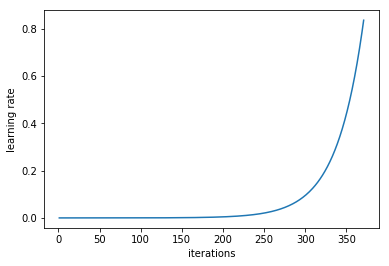

In [24]:
# here's what the above was doing to the learning rate, increasing it exponentially:
learn.sched.plot_lr()

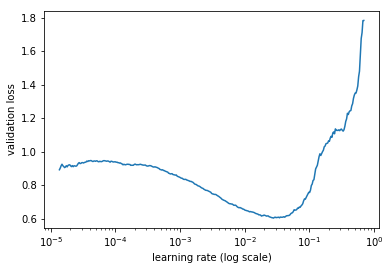

In [25]:
# and here's the effect this had on the loss:
learn.sched.plot()

We want to pick a learning rate where the loss is still clearly decreasing. The absolute minimum, the turning point in the above plot, may be a little too high. The loss is still clearly decreasing at 10<sup>-2</sup>, so we'll use that as the initial learning rate. This may change as the model is changed, so this should be re-run from time to time on a copy of the learn object.

### unfreezing layers
We have just calculated the optimal learning rate for the last hidden layer, assuming we are going to fine tune the model - that is, just train the last layer to work with new output categories. This would be fine if we were taking a network trained on ImageNet classification into the 1000 imagenet categories, and retraining it to recognise different but similar categories. We are retraining the network to a markedly different task of acting as a Scrabble move evaluator. This involves some of the same features (an appreciation of relative position, for example), but we probably still want to train the earlier layers. We'll set varying learning rates so that the earlier layers can still re-train, but the weights will move more slowly, since we expect the earlier layers to have learned more features in common with our task.

In [26]:
# We also want to start from the initial set of weights, 
# not the weights we've been messing with while finding 
# a learning rate, so we'll reset the weights:

shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [27]:
# This should already be false, but just in case:
learn.precompute=False

# now unfreeze all the layers:
learn.unfreeze()

In [7]:
lr = 0.01 # the learning rate we found above

# here we'll set the early, middle and late layers all to this learning rate, since we're learning everything from scratch:
lrs = np.array([lr,lr,lr])

In [28]:
# start fitting on the training samples, validating against the validation set (try 3 epochs to start)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.460831   0.418014   0.840544  
    1      0.4588     0.414305   0.844703                                                                              
    2      0.434272   0.40014    0.855519                                                                              
    3      0.473549   0.405806   0.854825                                                                              
    4      0.438509   0.387041   0.867304                                                                              
    5      0.418264   0.387368   0.863145                                                                              
    6      0.401995   0.382246   0.867304                                                                              


[array([0.38225]), 0.8673044925124792]

The cycle_len parameter used means that instead of doing 3 epochs, we are instead doing 3 cycles of epochs. The cycle_mult parameter means each cycle is twice as long as the last. So we are performing a cycle of 1, 2, and 4 epochs for a total of seven epochs. We are performing SGDR (Stochastic Gradient Descent with Restarts) such that after each cycle we the learning rate is reset.

We start off at the initial learning rate (0.01 in this case), and perform learning rate annealing so that the learning rate is reduced each batch. The learning will hopefully slow down as we approach a minimum.

After a cycle, our learning rate will jump up to 0.01 again.

This technique helps to explore multiple minima and hopefully end up in a more stable part of the weight space rather than being stuck in an unstable local minimum.

Our learning rate across epochs looks like this:

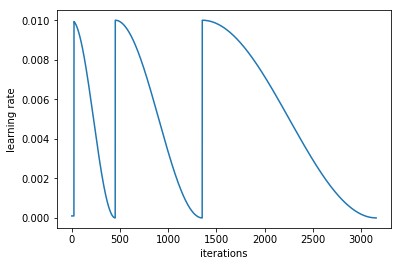

In [29]:
learn.sched.plot_lr()

In [30]:
# let's save our model so far:
learn.save('lsuv_initial_trained_model')

Now, over the last couple of epochs our accuracy seems to be going down - the loss on the training set is decreasing but the loss on the validation set (the samples we didn't train on) has started to increase, indicating we are starting to overfit to the training data. How are we actually doing?

In [31]:
# This is the list of labels for our validation set:
print([y for y in data.val_y])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
# these classes are as follows:
data.classes

['best', 'not_best']

In [33]:
data.val_y.shape

(7212,)

In [34]:
# so we know that label 0 represents 'best' moves and label 1 represents 'not_best' moves
# let's get predictions for our validation set, i.e. perform inference by
# just making a forward pass through the network:

# (predictions are a log scale)
log_preds = learn.predict()

# we should have 2 values per sample, a value giving how well 
# the model thinks that sample fits each of the 2 categories:
log_preds.shape

(7212, 2)

In [35]:
# let's look at a few:
log_preds[:-10]

array([[-0.04761, -3.06851],
       [-0.66512, -0.72198],
       [-1.79177, -0.18232],
       ...,
       [-2.78137, -0.06396],
       [-2.3132 , -0.10419],
       [-2.86399, -0.05873]], dtype=float32)

In [36]:
# convert these from a log scale to 0 or 1:
preds = np.argmax(log_preds, axis=1)
preds

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

[[ 858  945]
 [  12 5397]]


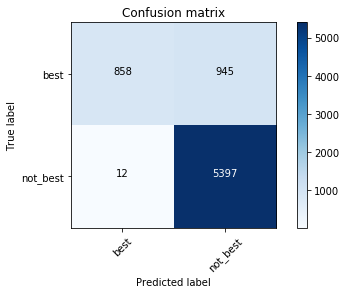

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

So we can see that for images that were not the 'best' move, our model is labelling them as not the best move around 95.8% of the time. For moves that are supposedly the 'best' move, those generated from Quackle, our model is labelling them as the best move only around 57.7% of the time.

This is still encouraging, since our evaluation method was poor in the first place - we are simply trusting that Quackle will have picked the best move and so the function we are approximating is not really which is the best move but rather out of the moves picked by Quackle and the moves picked by ALexIS, which are the most 'Quackle-like'.

In some situations, such as where it makes no odds to strategy because we are not exposing key squares to our opponent, the optimal choice for Quackle may well be similar to ALexIS' naive move evaluation function which simply picks the highest score, and in such cases there would be little to tell our two Scrabble simulations apart.

# Training on full data-set
We've performed some quick-and-dirty training on a small subset of the games, the first 200, in order to get a rough neural network. We can likely do better with more data, and so we can now take the rest of the data, discarding the earlier subset we trained on so as not to overfit to it any more. With the remaining 2366 games, we can now repeat the process. Since each has about 20-25 moves and each of those moves has 16 possible plays recorded, we are now training on about 340k images and validating on 85k.

In [ ]:
# let's copy our saved model to the main data directory:
!cp -r data/subset/models data/

In [22]:
PATH = "data/"
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [23]:
# in case any preprocessing is done after instantiating the Learner, 
# let's not just swap in the new data-set, let's just make a new object
# with the new data and load the old weights into it:

learn = ConvLearner.pretrained(arch, data, precompute=False)

In [24]:
learn.load('lsuv_initial_trained_model')



In [28]:
# retrain with the new data (just 1 epoch):
learn.fit(lrs, 1)

epoch      trn_loss   val_loss   accuracy                                          
    0      0.539851   15571.5    0.5       



[array([15571.5]), 0.5]

In [ ]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [ ]:
learn.save('epoch1')

In [ ]:
# let's do another couple of epochs:
learn.fit(lrs, 2)

In [ ]:
learn.save('epoch3')

In [ ]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [ ]:
# and another couple of epochs:
learn.fit(lrs, 2)

In [ ]:
learn.save('epoch5')

In [ ]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [ ]:
# and with restarts:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('epoch10')

In [ ]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)